In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

In [38]:
loss = pd.read_csv('../src/latest/train/loss.csv')
inf =  pd.read_csv('../src/latest/train/inferenced.csv')
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')
census = pd.read_csv('../data/raw/census_starter.csv')

#型変換
train['first_day_of_month'] = pd.to_datetime(train['first_day_of_month'])


In [39]:
feature_df = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')][['cfips', 'first_day_of_month','row_id']].copy()

In [40]:
##diff(2021/1⇒2021/2)特徴量
train['microbusiness_density_shift1'] = train.groupby('cfips')['microbusiness_density'].shift(1)
train['diff'] = train['microbusiness_density_shift1']- train['microbusiness_density']
train['diff_abs'] = train['diff'].abs()
train_old = train[train['first_day_of_month'] < pd.to_datetime('2021/2/1')]
train_old_gby = train_old.groupby('cfips')['diff_abs'].mean().reset_index()
train_diff = train[train['first_day_of_month'] == pd.to_datetime('2021/2/1')][['cfips','diff']]
diff_feature = pd.merge(train_old_gby, train_diff,on = 'cfips')
diff_feature['diff_1_2'] = diff_feature['diff']/diff_feature['diff_abs']

In [41]:
##ラグ特徴量
lag_features = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
lag_features_col = []
for shift_month in range(1,len(lag_features['first_day_of_month'].unique())):
    lag_features[f'mb_dens_shift{shift_month}'] = lag_features.groupby(['cfips'])[['microbusiness_density']].shift(shift_month)
    lag_features_col.append(f'mb_dens_shift{shift_month}')

<ipython-input-41-9234ba73bfd3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lag_features[f'mb_dens_shift{shift_month}'] = lag_features.groupby(['cfips'])[['microbusiness_density']].shift(shift_month)


In [42]:
## 群の数
cfips_amount = train.groupby('state')[['cfips']].nunique().reset_index().rename({"cfips":"cfips_amount"},axis = 1)
cfips_amount = pd.merge(train[['cfips','state']],cfips_amount , on = 'state')
cfips_amount = cfips_amount.groupby(['cfips'])[['cfips_amount','state']].last().reset_index()
state_dummies = pd.get_dummies(cfips_amount['state'])
cfips_amount[state_dummies.columns] =state_dummies
cfips_amount = cfips_amount.drop(columns = 'state')

In [43]:
#移動平均
rolling_features = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
rolling_features_col = []
for i in range(1,6):
    DAYS_PRED = i+1
    for size in [3, 6, 9, 12]:
        rolling_features[f"rolling_lag_mean_t{size}_shift{DAYS_PRED}"] = rolling_features.groupby(['cfips'])['microbusiness_density'].transform(lambda x: x.shift(DAYS_PRED).rolling(size).mean())
        rolling_features_col.append(f"rolling_lag_mean_t{size}_shift{DAYS_PRED}")

<ipython-input-43-127c639800c4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rolling_features[f"rolling_lag_mean_t{size}_shift{DAYS_PRED}"] = rolling_features.groupby(['cfips'])['microbusiness_density'].transform(lambda x: x.shift(DAYS_PRED).rolling(size).mean())


In [44]:
#分散
std_features = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
std_features_col = []
for i in range(1,6):
    DAYS_PRED = i+1
    for size in [3, 6, 9, 12]:
        std_features[f"rolling_lag_std_t{size}_shift{DAYS_PRED}"] = std_features.groupby(['cfips'])['microbusiness_density'].transform(lambda x: x.shift(DAYS_PRED).rolling(size).std())
        std_features_col.append(f"rolling_lag_std_t{size}_shift{DAYS_PRED}")

<ipython-input-44-cdb5f883023f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_features[f"rolling_lag_std_t{size}_shift{DAYS_PRED}"] = std_features.groupby(['cfips'])['microbusiness_density'].transform(lambda x: x.shift(DAYS_PRED).rolling(size).std())


In [45]:
#ターゲット
target = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
target['shift_target'] = target.groupby('cfips')['microbusiness_density'].shift(1)
target['target'] = target['microbusiness_density']/target['shift_target'] - 1

<ipython-input-45-fc5591258d5c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['shift_target'] = target.groupby('cfips')['microbusiness_density'].shift(1)
<ipython-input-45-fc5591258d5c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['target'] = target['microbusiness_density']/target['shift_target'] - 1


In [46]:
feature_df2 = pd.merge(feature_df,diff_feature,on = 'cfips')
feature_df2[lag_features_col] = lag_features[lag_features_col].values
feature_df3 = pd.merge(feature_df2,cfips_amount,on = 'cfips')
feature_df3[rolling_features_col] = rolling_features[rolling_features_col].values
feature_df3[std_features_col] = std_features[std_features_col].values
feature_df3['target'] = target['target'].values
feature_df3['shift_target'] = target['shift_target'].values
feature_df3['microbusiness_density'] = target['microbusiness_density'].values
mart = feature_df3[feature_df3['first_day_of_month'] >= pd.to_datetime('2021/3/1')]
mart['target'] = mart['target'].fillna(0)
mart['shift_target'] = mart['shift_target'].fillna(0)



<ipython-input-46-85eee7e7a319>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mart['target'] = mart['target'].fillna(0)
<ipython-input-46-85eee7e7a319>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mart['shift_target'] = mart['shift_target'].fillna(0)


In [56]:
train.loc[train['row_id'].isin(mart_val['row_id']),'microbusiness_density'] = preds

In [48]:
mart_train = mart[mart['first_day_of_month'] <= pd.to_datetime('2022/6/1')]
mart_val = mart[mart['first_day_of_month'] == pd.to_datetime('2022/7/1')]
mart_sub = mart[mart['first_day_of_month'] > pd.to_datetime('2022/7/1')]

In [52]:
dt = today + relativedelta(months=1)

,cfips,first_day_of_month,row_id,diff_abs,diff,diff_1_2,mb_dens_shift1,mb_dens_shift2,mb_dens_shift3,mb_dens_shift4,...,rolling_lag_std_t6_shift5,rolling_lag_std_t9_shift5,rolling_lag_std_t12_shift5,rolling_lag_std_t3_shift6,rolling_lag_std_t6_shift6,rolling_lag_std_t9_shift6,rolling_lag_std_t12_shift6,target,shift_target,microbusiness_density
17,1001,2022-07-01,1001_2022-07-01,0.058544,-0.158862,-2.713553,3.346197,3.313253,3.372082,3.336785,...,0.061988,0.051944,0.052166,0.052567,0.047176,0.038050,0.052149,0.027426,3.346197,3.437971
38,1003,2022-07-01,1003_2022-07-01,0.114693,0.102044,0.889711,8.507496,7.907365,7.979170,7.945311,...,0.070504,0.103921,0.109130,0.106048,0.077232,0.114839,0.104743,0.007754,8.507496,8.573463
59,1005,2022-07-01,1005_2022-07-01,0.043452,0.039892,0.918088,1.191678,1.186629,1.191678,1.196728,...,0.031652,0.030430,0.041078,0.020057,0.021662,0.027516,0.038038,0.021187,1.191678,1.216926
80,1007,2022-07-01,1007_2022-07-01,0.015240,0.022394,1.469431,1.275998,1.247892,1.253513,1.264755,...,0.021269,0.020504,0.030246,0.011773,0.017189,0.024384,0.034585,0.039647,1.275998,1.326588
101,1009,2022-07-01,1009_2022-07-01,0.018877,-0.076763,-4.066526,1.773202,1.748417,1.764189,1.797986,...,0.018512,0.021956,0.023047,0.010702,0.015567,0.015519,0.019841,0.033037,1.773202,1.831783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65747,56037,2022-07-01,56037_2022-07-01,0.063874,-0.278351,-4.357824,2.783238,2.820681,2.851883,2.848763,...,0.184149,0.233057,0.234647,0.084971,0.202079,0.209138,0.208997,0.019058,2.783238,2.836282
65768,56039,2022-07-01,56039_2022-07-01,0.152353,1.905317,12.505966,25.652266,25.506157,25.626175,25.636610,...,0.143783,0.120441,0.127683,0.157709,0.122894,0.100200,0.164825,0.011188,25.652266,25.939260
65789,56041,2022-07-01,56041_2022-07-01,0.106296,0.330898,3.112972,3.906035,3.885368,4.064481,4.023147,...,0.199090,0.208226,0.186751,0.164837,0.151267,0.153158,0.133261,0.019400,3.906035,3.981813
65810,56043,2022-07-01,56043_2022-07-01,0.041440,-0.446355,-10.771070,3.126551,2.944582,2.977668,3.010753,...,0.035496,0.041336,0.071051,0.017933,0.036339,0.043702,0.066290,0.031746,3.126551,3.225807


In [50]:
mart_train = mart_train[~mart_train['cfips'].isin([48301])]
mart_val = mart_val[~mart_val['cfips'].isin([48301])]

dtrain = lgb.Dataset(mart_train.drop(columns = ['cfips','first_day_of_month','target','shift_target','microbusiness_density','row_id']), mart_train['target'])
dvalid = lgb.Dataset(mart_val.drop(columns = ['cfips','first_day_of_month','target','shift_target','microbusiness_density','row_id']), mart_val['target'])
param = {
    'objective': 'regression', 
    'metric': 'mae',
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 40,
    'learning_rate': 0.01,
#     'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 0.4),
#     #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#     #'bagging_freq': trial.suggest_int('bagging_freq', 1, 30),
    'max_depth': 12,
    'min_child_samples': 150,
    'force_col_wise': True,
    'num_iterations' : 800,
#     'early_stopping_round':100,
#     'boosting' : boosting_type
}

gbm = lgb.train(param, dtrain, valid_sets=[dvalid],callbacks=[lgb.log_evaluation(100)])
preds = gbm.predict(mart_val.drop(columns = ['cfips','first_day_of_month','target','shift_target','microbusiness_density','row_id']))

C:\Users\ocn\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 14673
[LightGBM] [Info] Number of data points in the train set: 50144, number of used features: 104
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.002563
[100]	valid_0's l1: 0.0214695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

## データ更新

In [32]:
mart_train.iloc[0:20]

,cfips,first_day_of_month,diff_abs,diff,diff_1_2,mb_dens_shift1,mb_dens_shift2,mb_dens_shift3,mb_dens_shift4,mb_dens_shift5,...,rolling_lag_std_t6_shift5,rolling_lag_std_t9_shift5,rolling_lag_std_t12_shift5,rolling_lag_std_t3_shift6,rolling_lag_std_t6_shift6,rolling_lag_std_t9_shift6,rolling_lag_std_t12_shift6,target,shift_target,microbusiness_density
1,1001,2021-03-01,0.058544,-0.158862,-2.713553,3.106106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012214,3.106106,3.144043
2,1001,2021-04-01,0.058544,-0.158862,-2.713553,3.144043,3.106106,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025641,3.144043,3.224659
3,1001,2021-05-01,0.058544,-0.158862,-2.713553,3.224659,3.144043,3.106106,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000735,3.224659,3.227030
4,1001,2021-06-01,0.058544,-0.158862,-2.713553,3.227030,3.224659,3.144043,3.106106,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001470,3.227030,3.222288
5,1001,2021-07-01,0.058544,-0.158862,-2.713553,3.222288,3.227030,3.224659,3.144043,3.106106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003679,3.222288,3.210433
6,1001,2021-08-01,0.058544,-0.158862,-2.713553,3.210433,3.222288,3.227030,3.224659,3.144043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002954,3.210433,3.219917
7,1001,2021-09-01,0.058544,-0.158862,-2.713553,3.219917,3.210433,3.222288,3.227030,3.224659,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010309,3.219917,3.186722
8,1001,2021-10-01,0.058544,-0.158862,-2.713553,3.186722,3.219917,3.210433,3.222288,3.227030,...,NaN,NaN,NaN,0.060544,NaN,NaN,NaN,0.005208,3.186722,3.203320
9,1001,2021-11-01,0.058544,-0.158862,-2.713553,3.203320,3.186722,3.219917,3.210433,3.222288,...,NaN,NaN,NaN,0.047243,NaN,NaN,NaN,-0.000740,3.203320,3.200948
10,1001,2021-12-01,0.058544,-0.158862,-2.713553,3.200948,3.203320,3.186722,3.219917,3.210433,...,0.051338,NaN,NaN,0.002371,NaN,NaN,NaN,0.026667,3.200948,3.286307


In [25]:
train.loc[mart_val.index,'microbusiness_density'] = preds

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_shift1,diff,diff_abs
17,1001_2021-01-01,1001,Autauga County,Alabama,2021-01-01,2.947244,1243,3.002558,0.055314,0.055314
38,1001_2022-10-01,1001,Autauga County,Alabama,2022-10-01,3.463856,1472,3.442677,-0.021178,0.021178
59,1003_2021-04-01,1003,Baldwin County,Alabama,2021-04-01,8.032654,13382,7.978031,-0.054623,0.054623
80,1005_2019-10-01,1005,Barbour County,Alabama,2019-10-01,1.160149,240,0.995794,-0.164354,0.164354
101,1005_2021-07-01,1005,Barbour County,Alabama,2021-07-01,1.146903,230,1.107011,-0.039892,0.039892
...,...,...,...,...,...,...,...,...,...,...
65747,31067_2022-04-01,31067,Gage County,Nebraska,2022-04-01,1.543358,257,1.483305,-0.060053,0.060053
65768,31069_2020-10-01,31069,Garden County,Nebraska,2020-10-01,1.010101,15,1.010101,0.000000,0.000000
65789,31069_2022-07-01,31069,Garden County,Nebraska,2022-07-01,1.331558,20,1.198402,-0.133156,0.133156
65810,31071_2021-01-01,31071,Garfield County,Nebraska,2021-01-01,3.615960,58,3.694268,0.078307,0.078307


In [28]:
train.iloc[:20]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_shift1,diff,diff_abs
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,3.007682,0.122812,0.122812
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2.884870,-0.170973,0.170973
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,3.055843,0.062610,0.062610
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2.993233,0.000000,0.000000
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,2.993233,0.024143,0.024143
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2.969090,0.059764,0.059764
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227,2.909326,-0.023906,0.023906
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255,2.933231,-0.066936,0.066936
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257,3.000167,-0.004781,0.004781


In [20]:
mart_train = mart_train[~mart_train['cfips'].isin([48301])]
mart_val = mart_val[~mart_val['cfips'].isin([48301])]

dtrain = lgb.Dataset(mart_train.drop(columns = ['cfips','first_day_of_month','target','shift_target','microbusiness_density']), mart_train['target'])
dvalid = lgb.Dataset(mart_val.drop(columns = ['cfips','first_day_of_month','target','shift_target','microbusiness_density']), mart_val['target'])
param = {
    'objective': 'regression', 
    'metric': 'mae',
    'lambda_l1': 2,
    'lambda_l2': 5,
    'num_leaves': 40,
    'learning_rate': 0.005,
#     'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 0.4),
#     #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#     #'bagging_freq': trial.suggest_int('bagging_freq', 1, 30),
    'max_depth': 8,
    'min_child_samples': 150,
    'force_col_wise': True,
    'num_iterations' : 1000,
#     'early_stopping_round':100,
#     'boosting' : boosting_type
}

gbm = lgb.train(param, dtrain, valid_sets=[dvalid],callbacks=[lgb.log_evaluation(100)])
preds = gbm.predict(mart_val.drop(columns = ['cfips','first_day_of_month','target','shift_target','microbusiness_density']))

mart_val['preds'] = preds
mart_val['preds_mbd'] = (mart_val['preds']+1) * mart_val['shift_target']

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 14673
[LightGBM] [Info] Number of data points in the train set: 50144, number of used features: 104
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.002563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [ ]:
mart_val['preds'] = preds
mart_val['preds_mbd'] = (mart_val['preds']+1) * mart_val['shift_target']

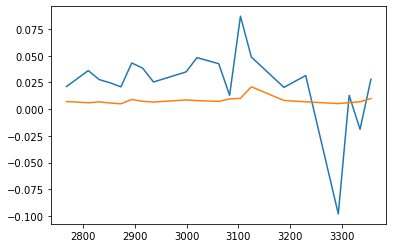

In [227]:
plt.plot(mart_val['target'].iloc[100:120])
plt.plot(mart_val['preds'].iloc[100:120])

In [228]:
mart_val['preds_mbd'] = (mart_val['preds']+1) * mart_val['shift_target']

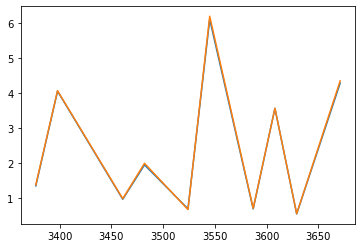

In [232]:
plt.plot(mart_val['preds_mbd'].iloc[120:130])
plt.plot(mart_val['microbusiness_density'].iloc[120:130])

In [281]:
inference_df = mart_val[['preds_mbd']].T.reset_index(drop = True)
inference_df.columns = mart_val['cfips'].values

In [282]:
inference_df

,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
0,3.365159,8.552429,1.196785,1.281963,1.779609,0.944739,1.994076,2.741352,1.478038,1.127854,...,1.721112,6.131871,3.227244,113.457613,7.771484,2.791617,25.757313,3.924413,3.141816,1.81021


In [265]:
loss = pd.DataFrame(tmp)
loss.columns = ['cfips', 'val_loss']

In [148]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

<AxesSubplot:xlabel='target2', ylabel='Count'>

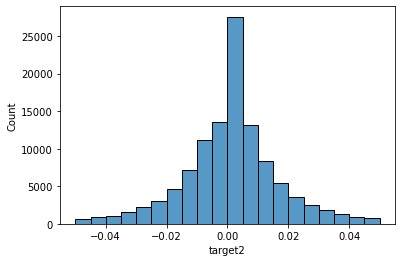

In [187]:
sns.histplot(train['target2'],bins = np.linspace(-0.05,0.05,21))

In [257]:
#ターゲット
target = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
target['target'] = target.groupby('cfips')['microbusiness_density'].shift(1)
target['target'] = target['microbusiness_density']/target['target'] - 1

<ipython-input-257-a96c058c4247>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['target'] = target.groupby('cfips')['microbusiness_density'].shift(1)
<ipython-input-257-a96c058c4247>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['target'] = target['microbusiness_density']/target['target'] - 1


In [258]:
target

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_shift1,diff,diff_abs,target
18,1001_2021-02-01,1001,Autauga County,Alabama,2021-02-01,3.106106,1310,2.947244,-0.158862,0.158862,NaN
19,1001_2021-03-01,1001,Autauga County,Alabama,2021-03-01,3.144043,1326,3.106106,-0.037937,0.037937,0.012214
20,1001_2021-04-01,1001,Autauga County,Alabama,2021-04-01,3.224659,1360,3.144043,-0.080617,0.080617,0.025641
21,1001_2021-05-01,1001,Autauga County,Alabama,2021-05-01,3.227030,1361,3.224659,-0.002371,0.002371,0.000735
22,1001_2021-06-01,1001,Autauga County,Alabama,2021-06-01,3.222288,1359,3.227030,0.004742,0.004742,-0.001470
...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,1.803249,0.000000,0.000000,0.000000
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,1.803249,0.000000,0.000000,0.000000
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,1.803249,0.017854,0.017854,-0.009901
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,1.785395,0.000000,0.000000,0.000000


In [240]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import json
import os

# --- Define Function ---
# ----- Metric -----
# Copy and Paste
# https://www.kaggle.com/code/cdeotte/seasonal-model-with-validation-lb-1-091
def smape(y_pred, y_true):
    # CONVERT TO NUMPY
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # WHEN BOTH EQUAL ZERO, METRIC IS ZERO
    both = np.abs(y_true) + np.abs(y_pred)
    idx = np.where(both==0)[0]
    y_true[idx]=1; y_pred[idx]=1
    
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
# -------------------------


# --- Set Paramters ---
data_folder = "../../data/raw"
train_filepath = os.path.join(data_folder, "train.csv")
test_filepath = os.path.join(data_folder, "test.csv")
census_starter_filepath = os.path.join(data_folder, "census_starter.csv")
submission_filepath = os.path.join(data_folder, "sample_submission.csv")
config_filepath = "./config.json"
save_dirpath = "./train"
loss_filepath = os.path.join(save_dirpath, "loss.csv")
inferenced_filepath = os.path.join(save_dirpath, "inferenced.csv")

# --- Preparation ---
# 変数の定義
train           = pd.read_csv(train_filepath)
test            = pd.read_csv(test_filepath)
census_starter  = pd.read_csv(census_starter_filepath)
submission      = pd.read_csv(submission_filepath)
# 設定ファイル関連
with open(config_filepath, mode="rt", encoding="utf-8") as f:
	config = json.load(f)
# CVのやり方（とりあえず別途管理するまでは、Noneにする）
cv_type  = None # cv_type = config["CV"]
# 評価方法
metric = smape
# 結果保存場所の環境作成
os.makedirs(save_dirpath, exist_ok=True)


# --- FeatureEngineering ---

#型変換
train['first_day_of_month'] = pd.to_datetime(train['first_day_of_month'])

#2021/2以降のデータを抽出
feature_df = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')][['cfips', 'first_day_of_month']].copy()

##diff(2021/1⇒2021/2)特徴量
train['microbusiness_density_shift1'] = train.groupby('cfips')['microbusiness_density'].shift(1)
train['diff'] = train['microbusiness_density_shift1']- train['microbusiness_density']
train['diff_abs'] = train['diff'].abs()
train_old = train[train['first_day_of_month'] < pd.to_datetime('2021/2/1')]
train_old_gby = train_old.groupby('cfips')['diff_abs'].mean().reset_index()
train_diff = train[train['first_day_of_month'] == pd.to_datetime('2021/2/1')][['cfips','diff']]
diff_feature = pd.merge(train_old_gby, train_diff,on = 'cfips')
diff_feature['diff_1_2'] = diff_feature['diff']/diff_feature['diff_abs']

##lag特徴量
lag_features = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
lag_features_col = []
for shift_month in range(1,len(lag_features['first_day_of_month'].unique())):
    lag_features[f'mb_dens_shift{shift_month}'] = lag_features.groupby(['cfips'])[['microbusiness_density']].shift(shift_month)
    lag_features_col.append(f'mb_dens_shift{shift_month}')
    
## 群の数
cfips_amount = train.groupby('state')[['cfips']].nunique().reset_index().rename({"cfips":"cfips_amount"},axis = 1)
cfips_amount = pd.merge(train[['cfips','state']],cfips_amount , on = 'state')
cfips_amount = cfips_amount.groupby(['cfips'])[['cfips_amount','state']].last().reset_index()
state_dummies = pd.get_dummies(cfips_amount['state'])
cfips_amount[state_dummies.columns] =state_dummies
cfips_amount = cfips_amount.drop(columns = 'state')

#移動平均
rolling_features = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
rolling_features_col = []
for i in range(1,6):
    DAYS_PRED = i+1
    for size in [3, 6, 9, 12]:
        rolling_features[f"rolling_lag_mean_t{size}_shift{DAYS_PRED}"] = rolling_features.groupby(['cfips'])['microbusiness_density'].transform(lambda x: x.shift(DAYS_PRED).rolling(size).mean())
        rolling_features_col.append(f"rolling_lag_mean_t{size}_shift{DAYS_PRED}")
        
#分散
std_features = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
std_features_col = []
for i in range(1,6):
    DAYS_PRED = i+1
    for size in [3, 6, 9, 12]:
        std_features[f"rolling_lag_std_t{size}_shift{DAYS_PRED}"] = std_features.groupby(['cfips'])['microbusiness_density'].transform(lambda x: x.shift(DAYS_PRED).rolling(size).std())
        std_features_col.append(f"rolling_lag_std_t{size}_shift{DAYS_PRED}")
        
#ターゲット
target = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
target['shift_target'] = target.groupby('cfips')['microbusiness_density'].shift(1)
target['target'] = target['microbusiness_density']/target['shift_target'] - 1

#各種特徴量をマージ
feature_df2 = pd.merge(feature_df,diff_feature,on = 'cfips')
feature_df2[lag_features_col] = lag_features[lag_features_col].values
feature_df3 = pd.merge(feature_df2,cfips_amount,on = 'cfips')
feature_df3[rolling_features_col] = rolling_features[rolling_features_col].values
feature_df3[std_features_col] = std_features[std_features_col].values
feature_df3['target'] = target['target'].values
feature_df3['shift_target'] = target['shift_target'].values
feature_df3['microbusiness_density'] = target['microbusiness_density'].values
mart = feature_df3[feature_df3['first_day_of_month'] >= pd.to_datetime('2021/3/1')]
mart['target'] = mart['target'].fillna(0)
mart['shift_target'] = mart['shift_target'].fillna(0)

#Train/Validation/Submissionにデータ分ける
mart_train = mart[mart['first_day_of_month'] <= pd.to_datetime('2022/6/1')]
mart_val = mart[mart['first_day_of_month'] == pd.to_datetime('2022/7/1')]
mart_sub = mart[mart['first_day_of_month'] > pd.to_datetime('2022/7/1')]


#学習⇒validation期間の推論
mart_train = mart_train[~mart_train['cfips'].isin([48301])]
mart_val = mart_val[~mart_val['cfips'].isin([48301])]

dtrain = lgb.Dataset(mart_train.drop(columns = ['cfips','first_day_of_month','target','shift_target','microbusiness_density']), mart_train['target'])
dvalid = lgb.Dataset(mart_val.drop(columns = ['cfips','first_day_of_month','target','shift_target','microbusiness_density']), mart_val['target'])
param = {
    'objective': 'regression', 
    'metric': 'mae',
    'lambda_l1': 2,
    'lambda_l2': 5,
    'num_leaves': 40,
    'learning_rate': 0.005,
#     'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 0.4),
#     #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#     #'bagging_freq': trial.suggest_int('bagging_freq', 1, 30),
    'max_depth': 8,
    'min_child_samples': 150,
    'force_col_wise': True,
    'num_iterations' : 1000,
#     'early_stopping_round':100,
#     'boosting' : boosting_type
}

gbm = lgb.train(param, dtrain, valid_sets=[dvalid],callbacks=[lgb.log_evaluation(100)])
preds = gbm.predict(mart_val.drop(columns = ['cfips','first_day_of_month','target','shift_target','microbusiness_density']))

mart_val['preds'] = preds
mart_val['preds_mbd'] = (mart_val['preds']+1) * mart_val['shift_target']


# --- Post ---
# loss.csv
tmp = []
tmp2 = []
for i in range(len(mart_val)):
    tmp2.append(mart_val['cfips'].iloc[i])
    loss = smape(np.array([mart_val['microbusiness_density'].iloc[i]]), 
                np.array([mart_val['preds_mbd'].iloc[i]]))
    tmp2.append(loss)
    tmp.append(tmp2)
    tmp2 = []
loss = pd.DataFrame(tmp)
loss.columns = ['cfips', 'val_loss']
loss.to_csv(loss_filepath, index = False)


# predict.csv (いいやり方ではないと思う。。。とりあえずバリデーション期間が変わってもできるように)
inference_df = mart_val[['preds_mbd']].T.reset_index(drop = True)
inference_df.columns = mart_val['cfips'].values
inference_df.to_csv(inferenced_filepath, index = False)

,Unnamed: 0,1001,1003,1005,1007,1009,1011,1013,1015,1017,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
0,0,3.358391,8.527954,1.197156,1.274116,1.781013,0.932395,2.027105,2.721766,1.470942,...,1.736348,6.102116,3.194106,115.987065,7.789963,2.782922,25.595867,3.880484,3.143340,1.811091
1,1,3.370585,8.548413,1.202635,1.272233,1.788824,0.927370,2.070524,2.718950,1.472907,...,1.759634,6.103003,3.175247,118.774781,7.840028,2.782606,25.539467,3.854934,3.160129,1.818932
2,2,3.382778,8.568871,1.208113,1.270351,1.796635,0.922344,2.113942,2.716133,1.474871,...,1.782920,6.103890,3.156388,121.562496,7.890093,2.782290,25.483068,3.829383,3.176918,1.826773
3,3,3.394972,8.589330,1.213591,1.268469,1.804446,0.917319,2.157361,2.713317,1.476836,...,1.806206,6.104777,3.137529,124.350212,7.940158,2.781974,25.426669,3.803833,3.193707,1.834614


In [6]:
class LGBModel:
    def __init__(self, _cfips_config, _metric):
        self.config = _cfips_config
        self.metric = _metric
        self.data = None
        self.train_x = None
        self.train_y = None
        self.val_x = None
        self.val_y = None
        self.sub_x = None
        self.sub_y = None
        self.predict_val = None
        self.metric_val = None
        self.modelinstance = None

    def set_data(self, _data):
        self.train = _data
    
    def feature_engioneering(self):
        feature_df = self.train[self.train['first_day_of_month'] >= pd.to_datetime('2021/2/1')][['cfips', 'first_day_of_month']].copy()
        
        ##diff(2021/1⇒2021/2)特徴量
        self.train['microbusiness_density_shift1'] = self.train.groupby('cfips')['microbusiness_density'].shift(1)
        self.train['diff'] = self.train['microbusiness_density_shift1']- self.train['microbusiness_density']
        self.train['diff_abs'] = self.train['diff'].abs()
        train_old = self.train[self.train['first_day_of_month'] < pd.to_datetime('2021/2/1')]
        train_old_gby = train_old.groupby('cfips')['diff_abs'].mean().reset_index()
        train_diff = self.train[self.train['first_day_of_month'] == pd.to_datetime('2021/2/1')][['cfips','diff']]
        diff_feature = pd.merge(train_old_gby, train_diff,on = 'cfips')
        diff_feature['diff_1_2'] = diff_feature['diff']/diff_feature['diff_abs']
        
        
        ##lag特徴量
        lag_features = self.train[self.train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
        lag_features_col = []
        for shift_month in range(1,len(lag_features['first_day_of_month'].unique())):
            lag_features[f'mb_dens_shift{shift_month}'] = lag_features.groupby(['cfips'])[['microbusiness_density']].shift(shift_month)
            lag_features_col.append(f'mb_dens_shift{shift_month}')

        ## 群の数
        cfips_amount = train.groupby('state')[['cfips']].nunique().reset_index().rename({"cfips":"cfips_amount"},axis = 1)
        cfips_amount = pd.merge(train[['cfips','state']],cfips_amount , on = 'state')
        cfips_amount = cfips_amount.groupby(['cfips'])[['cfips_amount','state']].last().reset_index()
        state_dummies = pd.get_dummies(cfips_amount['state'])
        cfips_amount[state_dummies.columns] =state_dummies
        cfips_amount = cfips_amount.drop(columns = 'state')

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01
...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01
25076,56039_2023-06-01,56039,2023-06-01
25077,56041_2023-06-01,56041,2023-06-01
25078,56043_2023-06-01,56043,2023-06-01


In [ ]:
def feature_engineering():
    feature_df = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')][['cfips', 'first_day_of_month']].copy()

In [ ]:
#2021/2以降のデータを抽出
feature_df = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')][['cfips', 'first_day_of_month']].copy()

##diff(2021/1⇒2021/2)特徴量
train['microbusiness_density_shift1'] = train.groupby('cfips')['microbusiness_density'].shift(1)
train['diff'] = train['microbusiness_density_shift1']- train['microbusiness_density']
train['diff_abs'] = train['diff'].abs()
train_old = train[train['first_day_of_month'] < pd.to_datetime('2021/2/1')]
train_old_gby = train_old.groupby('cfips')['diff_abs'].mean().reset_index()
train_diff = train[train['first_day_of_month'] == pd.to_datetime('2021/2/1')][['cfips','diff']]
diff_feature = pd.merge(train_old_gby, train_diff,on = 'cfips')
diff_feature['diff_1_2'] = diff_feature['diff']/diff_feature['diff_abs']

##lag特徴量
lag_features = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
lag_features_col = []
for shift_month in range(1,len(lag_features['first_day_of_month'].unique())):
    lag_features[f'mb_dens_shift{shift_month}'] = lag_features.groupby(['cfips'])[['microbusiness_density']].shift(shift_month)
    lag_features_col.append(f'mb_dens_shift{shift_month}')
    
## 群の数
cfips_amount = train.groupby('state')[['cfips']].nunique().reset_index().rename({"cfips":"cfips_amount"},axis = 1)
cfips_amount = pd.merge(train[['cfips','state']],cfips_amount , on = 'state')
cfips_amount = cfips_amount.groupby(['cfips'])[['cfips_amount','state']].last().reset_index()
state_dummies = pd.get_dummies(cfips_amount['state'])
cfips_amount[state_dummies.columns] =state_dummies
cfips_amount = cfips_amount.drop(columns = 'state')

#移動平均
rolling_features = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
rolling_features_col = []
for i in range(1,6):
    DAYS_PRED = i+1
    for size in [3, 6, 9, 12]:
        rolling_features[f"rolling_lag_mean_t{size}_shift{DAYS_PRED}"] = rolling_features.groupby(['cfips'])['microbusiness_density'].transform(lambda x: x.shift(DAYS_PRED).rolling(size).mean())
        rolling_features_col.append(f"rolling_lag_mean_t{size}_shift{DAYS_PRED}")
        
#分散
std_features = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
std_features_col = []
for i in range(1,6):
    DAYS_PRED = i+1
    for size in [3, 6, 9, 12]:
        std_features[f"rolling_lag_std_t{size}_shift{DAYS_PRED}"] = std_features.groupby(['cfips'])['microbusiness_density'].transform(lambda x: x.shift(DAYS_PRED).rolling(size).std())
        std_features_col.append(f"rolling_lag_std_t{size}_shift{DAYS_PRED}")
        
#ターゲット
target = train[train['first_day_of_month'] >= pd.to_datetime('2021/2/1')]
target['shift_target'] = target.groupby('cfips')['microbusiness_density'].shift(1)
target['target'] = target['microbusiness_density']/target['shift_target'] - 1

#各種特徴量をマージ
feature_df2 = pd.merge(feature_df,diff_feature,on = 'cfips')
feature_df2[lag_features_col] = lag_features[lag_features_col].values
feature_df3 = pd.merge(feature_df2,cfips_amount,on = 'cfips')
feature_df3[rolling_features_col] = rolling_features[rolling_features_col].values
feature_df3[std_features_col] = std_features[std_features_col].values
feature_df3['target'] = target['target'].values
feature_df3['shift_target'] = target['shift_target'].values
feature_df3['microbusiness_density'] = target['microbusiness_density'].values
mart = feature_df3[feature_df3['first_day_of_month'] >= pd.to_datetime('2021/3/1')]
mart['target'] = mart['target'].fillna(0)
mart['shift_target'] = mart['shift_target'].fillna(0)

#Train/Validation/Submissionにデータ分ける
mart_train = mart[mart['first_day_of_month'] <= pd.to_datetime('2022/6/1')]
mart_val = mart[mart['first_day_of_month'] == pd.to_datetime('2022/7/1')]
mart_sub = mart[mart['first_day_of_month'] > pd.to_datetime('2022/7/1')]

In [60]:
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_shift1,diff,diff_abs
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,3.007682,0.122812,0.122812
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2.884870,-0.170973,0.170973
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,3.055843,0.062610,0.062610
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2.993233,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,1.803249,0.000000,0.000000
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,0.007226,101,1.803249,0.000000,0.000000
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,1.803249,0.017854,0.017854
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,1.785395,0.000000,0.000000


In [66]:
train['cfips']== 1001,train['cfips']== 1001,

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_shift1,diff,diff_abs
35,1001_2022-07-01,1001,Autauga County,Alabama,2022-07-01,0.004353,1461,3.346197,-0.091773,0.091773


In [69]:
train.loc[(train['cfips']== 1001) &( train['first_day_of_month'].isin(['2022/7/1']))]['microbusiness_density'].values

array([0.00435288])

In [81]:
pd.concat([train.loc[train['first_day_of_month'].isin(['2022/7/1']),['microbusiness_density']].reset_index(drop = True).T,
train.loc[train['first_day_of_month'].isin(['2022/8/1']),['microbusiness_density']].reset_index(drop = True).T], axis = 0)

,0,1,2,3,4,5,6,7,8,9,...,3125,3126,3127,3128,3129,3130,3131,3132,3133,3134
microbusiness_density,0.004353,0.006665,0.009065,0.006651,0.005584,0.011287,0.007663,0.005116,0.009631,0.007686,...,0.003580,0.005265,0.004239,0.002857,0.007078,-0.00092,0.003854,0.004563,0.003956,0.007226
microbusiness_density,3.423852,8.491150,1.196728,1.292861,1.836289,0.962757,2.107667,2.788231,1.521846,1.131609,...,1.766595,6.221535,3.156099,113.441690,7.779387,2.81132,26.085369,3.974924,3.209264,1.785395


In [85]:
def smape(y_pred, y_true):
    # CONVERT TO NUMPY
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # WHEN BOTH EQUAL ZERO, METRIC IS ZERO
    both = np.abs(y_true) + np.abs(y_pred)
    idx = np.where(both==0)[0]
    y_true[idx]=1; y_pred[idx]=1
    
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
# -------------------------

In [90]:
val_date = ['2022/8/1', '2022/9/1', '2022/10/1']
for cfip in train['cfips'].unique()[:10]:
    smape(train.loc[(train['cfips']== cfip) &( train['first_day_of_month'].isin(val_date))]['microbusiness_density'].values,
          train.loc[(train['cfips']== cfip) &( train['first_day_of_month'].isin(val_date))]['microbusiness_density'].values)

In [100]:
 pd.concat([train.loc[train['first_day_of_month'].isin(val_date),['microbusiness_density']].reset_index(drop = True).T] + 
        [train.loc[train['first_day_of_month'].isin([pd.to_datetime(sub)]),['microbusiness_density']].reset_index(drop = True).T for sub in val_date])

,0,1,2,3,4,5,6,7,8,9,...,9395,9396,9397,9398,9399,9400,9401,9402,9403,9404
microbusiness_density,3.423852,3.442677,3.463856,8.491150,8.341701,8.359798,1.196728,1.206827,1.232074,1.292861,...,26.27322,3.974924,3.995591,4.009369,3.209264,3.209264,3.126551,1.785395,1.785395,1.785395
microbusiness_density,3.423852,8.491150,1.196728,1.292861,1.836289,0.962757,2.107667,2.788231,1.521846,1.131609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
microbusiness_density,3.442677,8.341701,1.206827,1.315346,1.852060,0.975424,2.166395,2.809447,1.502964,1.131609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
microbusiness_density,3.463856,8.359798,1.232074,1.287240,1.831783,0.988092,2.185970,2.800514,1.442544,1.117345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
for sub in val_date:
    print(sub)

2022/8/1
2022/9/1
2022/10/1
